<a href="https://colab.research.google.com/github/CrackHegg/Reverse-Balderdash/blob/main/10315_Mini_Project_WordGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whimsical and Wonderful WordGen

Members:

*   Ryan Ding
*   Jessica Han
*   Pranavi Kondapalli





# Training Flag(default = False)


In [ ]:
training_flag = False

# Imports


In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import torch
import os
import random
import numpy as np
import pandas as pd
import math
import sys
import time
from time import sleep

from IPython import display

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.nn.utils.rnn import pad_sequence

import sentencepiece as spm


from torch.optim import AdamW

from tqdm import tqdm
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

from datasets import Dataset

# ***Model Card***

**Task Input and Output**:

Inputs: A string of natural language text representing a definition or phrase describing a word
*   Example Input: "To leave hastily and secretly."

Outputs: A predicted word as a string, composed from BPE tokens
*   Example Output: "abscond"



**Training Data**:

[Larger Dictionary of English Words and Definitions - Kaggle](https://www.kaggle.com/datasets/anthonytherrien/larger-dictionary-of-english-words-and-definitions/data )

Preprocessing:

*   Definitions and words were tokenized separately using SentencePiece
*   Words and Definitions were converted to subword tokens using a BPE tokenizer trained over the word vocabulary
*   Definition were cleaned by removing instance of word from definition and by removing several key "classification" words.


*Size:* ~100,000+ word-definition pairs

**Training Data(used for pretrained GPT-2)**:


[WebText Dataset](https://huggingface.co/datasets/Skylion007/openwebtext)
(the dataset is not availible publically, but we included an open source replication)

*Size:* ~8 million documents (around 40 GB)

**Intended Use**:

*   Creative writing prompts
*   Word association games or quizzes(Reverse Balderdash)
*   Educational tools for vocabulary learning


**Risks**:
*   If definitions include culturally sensitive or offensive phrases, the model may reproduce inappropriate words from training data.
*   Since the dataset contains real dictionary data, some outdated or offensive terms may be embedded in the training distribution.



# ***Introduction***

You know when you have the idea of a word on the tip of your tongue but you just can't find it? Worry no more! As you can generate a whole new word to describe your thoughts!

---

Formally, our project aims to generate words, potentially invented ones, given their definitions. The goal is to create a model that takes in a description/definition of our word and outputs the word, even if it doesn't exist in current vocabularies. The capability to generate new names from precise definitions makes this project particularly useful for creative industries. It takes in existing human linguistics elements and outputs something novel and innovative.

**Techniques:**

*   *Word Embeddings:* We used nn.Embedding layers to represent discrete input tokens (from definitions) as continuous vectors. These embeddings allow the model to generalize across similar subwords and semantic structures.
*   *Scaled Dot Product Attention(SDPA) Transformers:* We leveraged the multi-head self-attention blocks of a pretrained GPT-2 model and finetuned the last layer(LM-head) of the model. Uses beam-search to find the most likely sequence of tokens.

**Experimental Question(s):**

*   Does the model, when generating words from definitions, over-rely on a small subset of subword tokens?
*   Can this reliance be mitigated through architectural choices like multi-headed attention?

# Download Kaggle Word Dataset

In [ ]:
!pip install gdown

In [ ]:
import os
import zipfile
import gdown

# 🧲 Download dataset from Google Drive using file ID
# https://drive.google.com/file/d/1p-PiJqz5cVOkeUWIYDVrgAZ0qDyYgh_-/view?usp=sharing
file_id = '1p-PiJqz5cVOkeUWIYDVrgAZ0qDyYgh_-'
output = 'words_definitions.zip'

# Construct the direct download link
download_link = f'https://drive.google.com/uc?id={file_id}'

gdown.download(download_link, output, quiet=False)

# 🗜️ Unzip it
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('word_dataset')

# ✅ Path to dataset
DATA_PATH = 'word_dataset'

Downloading...
From: https://drive.google.com/uc?id=1p-PiJqz5cVOkeUWIYDVrgAZ0qDyYgh_-
To: /content/words_definitions.zip
100%|██████████| 15.3M/15.3M [00:00<00:00, 57.7MB/s]


# Process Dataset

Remove repeated instances of the word from the definition and clean out taxonomies and classifications from the dictionary.

In [ ]:
#before cleaning
dataset = pd.read_csv(os.path.join(DATA_PATH, 'dict.csv'))
dataset.head()

print(f"Total unique words: {len(dataset['word'].unique())}")
print(f"Total definitions: {len(dataset['definition'])}")

Total unique words: 41298
Total definitions: 126132


**Show 5 Random Samples**

In [ ]:
for i in range(5):
  idx = random.randint(0, len(dataset) - 1)
  print(f"{i+1}. Word: {dataset.iloc[idx]['word']}")
  print(f"Definition: {dataset.iloc[idx]['definition']}")
  print()

1. Word: velar
Definition: The word 'velar' is an adjective that refers to a specific place of articulation in phonetics. It describes sounds that are produced with the back of the tongue against the soft palate (also known as the velum). Examples of velar consonants in English include the sounds represented by the letters "k," "g," and "ng" in words like "cat," "go," and "sing." Additionally, 'velar' can also relate to or pertain to the velum itself in anatomical contexts.

2. Word: pluck
Definition: The word "pluck" has several meanings in English:

1. **To pull or tug something quickly or forcibly:** This can refer to removing something from its place, such as plucking a flower from a plant or plucking a string on a musical instrument.

2. **To gather or harvest:** Often used in the context of fruits or vegetables, for example, plucking apples from a tree.

3. **To take courage or resolve in the face of difficulty:** This usage often refers to someone showing bravery or determinatio

In [ ]:
def remove_instances (sentence, word):
  idx = sentence.find(word)
  sentence = sentence[idx+(len(word))+2:]
  idx = sentence.find(' ')
  sentence = sentence[idx+1:]
  idx = sentence.find(' ')
  sentence = sentence[idx+1:]

  sentence = sentence.replace(word, "")
  return sentence

def limit_sentences (paragraph, num_sentences):
  idx = paragraph.find('.')
  i = 1
  while i < num_sentences and idx != -1:
    idx = paragraph.find('.', idx)
    i += 1

  if idx == -1:
    return paragraph

  paragraph = paragraph[0:idx]
  return paragraph


classifications = {'domain', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'taxonomy', 'country', 'language',
                    'state', 'continent', 'culture', 'peninsula', 'island', '**', 'medical', 'medicine', 'mineral', '1', 'as both', 'scientific name'
                    "- as a"}
def is_taxonomy (definition):
  if any(word in definition for word in classifications):
    return True
  return False

In [ ]:
drop_idx = np.zeros(dataset.shape[0])

# limit words or sentences
for idx in range((dataset.shape[0])):

  word = dataset.iloc[idx, 0]
  definition = dataset.iloc[idx, 1]

  # change it!
  if type(word) is str and type(definition) is str:
    word = word.lower()
    definition = definition.lower()

    # print(definition, is_taxonomy(definition))
    if is_taxonomy(definition):
      # dataset.drop(idx, axis=0, inplace=True)
      # print(dataset.shape)
      drop_idx[idx] = 1
      continue

    definition = remove_instances(definition, word)
    definition = limit_sentences(definition, 2)
    dataset.iloc[idx, 0] = word
    dataset.iloc[idx, 1] = definition


In [ ]:
drop_idx = drop_idx.astype(bool)
dataset = dataset[~drop_idx]

# Tokenizer

Use SentencePiece Byte Pair Encodings(BPE) to tokenize the definition and the word seperately. It is tokenized after the dataset has been cleaned.

In [ ]:
#convert dataset to dictionary mapping definitions to words
definition_to_word = {}
for index, row in dataset.iterrows():
    definition_to_word[row['definition']] = row['word']

In [ ]:
# clean and put definitions and words into .txt for tokenization
with open("definitions.txt", "w", encoding="utf-8") as f:
  for idx in range((dataset.shape[0])):

    word = dataset.iloc[idx]['word']
    definition = dataset.iloc[idx]['definition']
    if not is_taxonomy(definition):
        f.write(definition.strip() + "\n")

with open("words.txt", "w", encoding="utf-8") as f:
  for idx in range((dataset.shape[0])):

    word = dataset.iloc[idx]['word']
    definition = dataset.iloc[idx]['definition']
    if not is_taxonomy(definition):
      f.write(str(word).strip() + "\n")

In [ ]:
#definitions
spm.SentencePieceTrainer.Train(
    input="definitions.txt",
    model_prefix='definition_tokenizer',
    vocab_size=1600,
    model_type = "word",
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)

#words
spm.SentencePieceTrainer.Train(
    input="words.txt",
    model_prefix="word_tokenizer",
    vocab_size=1600,
    model_type="bpe",
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)

In [ ]:
sp_def = spm.SentencePieceProcessor()
sp_word = spm.SentencePieceProcessor()

sp_def.load("definition_tokenizer.model")
sp_word.load("word_tokenizer.model")

True

In [ ]:
#demo
encoded_def = sp_def.encode("a domesticated feline animal", out_type=int)
print("Definition Tokens:", encoded_def)

encoded_word = sp_word.encode("cat", out_type=int)
print("Word Tokens:", encoded_word)

print("Decoded:", sp_word.decode(encoded_word))


Definition Tokens: [5, 1, 257]
Word Tokens: [501]
Decoded: cat




---



---





---



---



# ***METHODS***

# Word Embeddings Model

Word Embeddings: We used nn.Embedding layers to represent discrete input tokens (from definitions) as continuous vectors. These embeddings allow the model to generalize across similar subwords and semantic structures.

Sequence Mean Pooling: Used mean pooling over the token embeddings of the definition sequence. This gives us a single fixed-length vector representation of the entire input sentence.

Linear Projection as Decoder: The pooled embedding is passed through a fully-connected (linear) layer to predict a fixed-length sequence of output tokens that represent the target word. Each position in the output is trained to predict one token of the target word's subword representation.

In [ ]:
class DefToWordModel(nn.Module):
    def __init__(self, vocab_size_def, vocab_size_word, embed_dim, word_len):
        super().__init__()
        self.vocab_size_def = vocab_size_def
        self.vocab_size_word = vocab_size_word
        self.word_len = word_len

        self.embedding_def = nn.Embedding(vocab_size_def, embed_dim)
        self.linear = nn.Linear(embed_dim, embed_dim)
        self.output = nn.Linear(embed_dim, vocab_size_word * word_len)

    def forward(self, def_input):
        def_embed =  self.embedding_def(def_input)
        pooled = def_embed.mean(dim=1)
        x = self.linear(pooled)
        x = self.output(x)
        x = x.view(-1,self.word_len,self.vocab_size_word)
        return x

# ***Word Embeddings Training***

**Run only ONE of the techniques at a time for training and experiments**

In [ ]:
# USE GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# CROSS ENTROPY LOSS
losses = []
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

# Tokenizer Vocab Sizes
vocab_size_def = sp_def.get_piece_size()
vocab_size_word = sp_word.get_piece_size()

# HYPERPARAMETERS
max_word_len = 6
max_def_len = 48
learning_rate = 0.005

# MODEL
definitions= dataset["definition"].tolist()
words= dataset["word"].tolist()

model = DefToWordModel(vocab_size_def=vocab_size_def, vocab_size_word=vocab_size_word, embed_dim=128, word_len=max_word_len).to(device)

device: cpu


# **1st WE Technique**

Predict whole word all at once(sequence of 6 most likely tokens)

In [ ]:
path = 'def_to_word_WE1_state_dict.pt'

In [ ]:
# HYPERPARAMETERS
max_word_len = 6
max_def_len = 48
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
if training_flag:
    for epoch in range(10):
        model.train()
        total_loss = 0
        i = 0

        # for def_batch, word_batch in dataloader:
        for definition, word in definition_to_word.items():
            # tokenize definition, word pairs and pad with empty tokens
            def_ids = sp_def.encode(str(definition), out_type=int)[:max_def_len]
            def_ids += [0] * (max_def_len - len(def_ids))

            word_ids = sp_word.encode(str(word), out_type=int)[:max_word_len]
            word_ids += [0] * (max_word_len - len(word_ids))


            def_batch = torch.tensor([def_ids], dtype=torch.long).to(device)
            word_batch = torch.tensor([word_ids], dtype=torch.long).to(device)

            i += 1
            if i % 10000 == 0:
                print(i)

            model.zero_grad()

            # get output and loss
            logits = model(def_batch)

            loss = loss_fn(logits.view(-1,logits.size(-1)), word_batch.view(-1))

            # propagate
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

        losses.append(total_loss)

    print(losses)

    torch.save(model.state_dict(), path)

In [ ]:
if training_flag:
  # Plot training loss over epochs
  plt.figure(figsize=(8, 5))
  plt.plot(range(1, len(losses) + 1), losses, marker='o')
  plt.title("Training Loss over Epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Total Loss")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

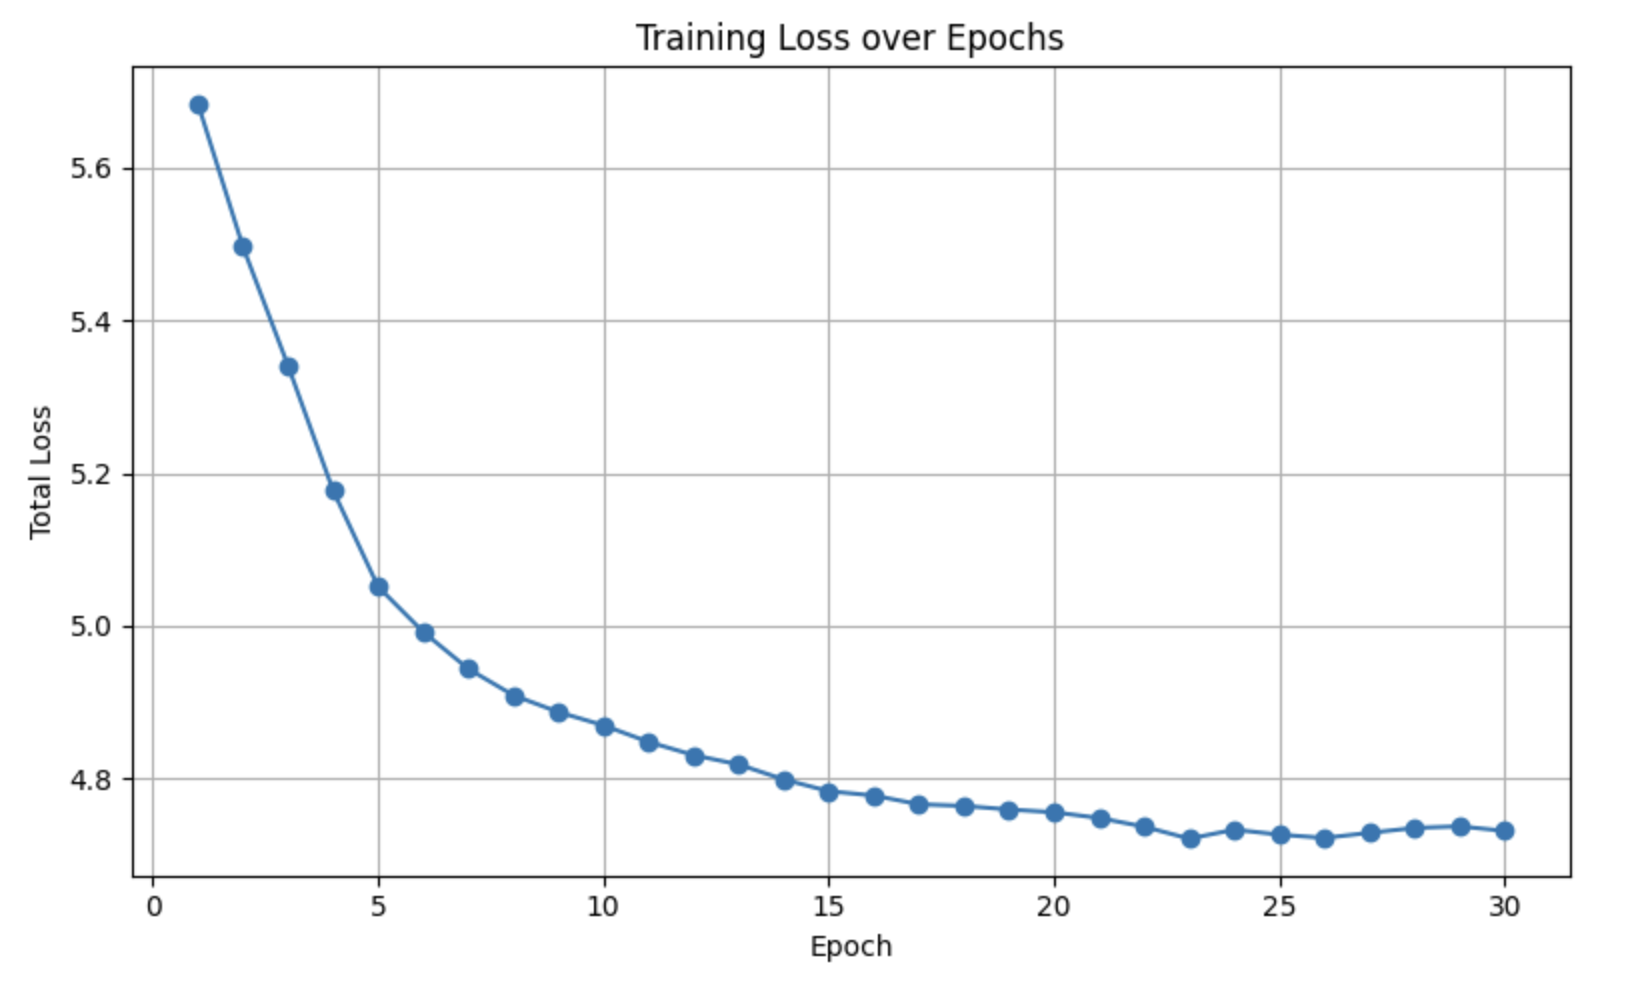

# **2nd WE Technique**

Predict the next token based on sequence of tokens

For example, the model first predicts token "ka". Then, after, it will predict a new token with [Definition]+"ka", so it'll have more have context when predicting the next token.

In [ ]:
path = 'def_to_word_WE2_state_dict.pt'

In [ ]:
# HYPERPARAMETERS
max_word_len = 1
max_def_len = 48
learning_rate = 0.001


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
if training_flag:
    for epoch in range(10):
        model.train()
        total_loss = 0
        i = 0

        for definition, word in definition_to_word.items():
            def_ids = sp_word.encode(str(definition), out_type=int)[:max_def_len]
            word_ids = sp_word.encode(str(word), out_type=int)
            i += 1
            if i % 10000 == 0:
                print(i)
            for word_idx in range(len(word_ids)):
                def_tks = def_ids + word_ids[0:word_idx]
                word_tks = word_ids[word_idx]

                if len(def_tks) < max_def_len:
                    def_tks += [0] * (max_def_len - len(def_tks))

                def_tks = def_tks[len(def_tks)-max_def_len:]

                # print(sp_def.decode(def_tks), sp_word.decode([word_tks]), sp_word.decode([word_ids]))

                def_batch = torch.tensor([def_tks], dtype=torch.long).to(device)
                word_batch = torch.tensor([word_tks], dtype=torch.long).to(device)


                model.zero_grad()

                # get output and loss
                logits = model(def_batch).squeeze()
                # print(logits.shape, word_batch.shape)

                loss = loss_fn(logits.view(-1,logits.size(-1)), word_batch.view(-1))

                # propagate
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            # break

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

        losses.append(total_loss)

    print(losses)

    torch.save(model.state_dict(), path)

In [ ]:
if training_flag:
  # Plot training loss over epochs
  plt.figure(figsize=(8, 5))
  plt.plot(range(1, len(losses) + 1), losses, marker='o')
  plt.title("Training Loss over Epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Total Loss")
  plt.grid(True)
  plt.tight_layout()
  plt.show()



---


---





---



---



# **Transformer Model**

Our transformer model feeds the tokenized definition through the frozen multi-headed self-attention layers of a pretrained GPT-2, then mean-pools its final hidden states.

A linear head—fine-tuned on our definition→word pairs predicts the next subword given the next true subword to generate the target word.


![](https://drive.google.com/uc?export=view&id=1OBPz2zIm1rV5ZYGr60Jv2yojVK-Cz-mY)

In [ ]:
definitions = list(definition_to_word.keys())
words       = list(definition_to_word.values())

In [ ]:
# load pretrained GPT and its tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.config.pad_token_id = tokenizer.pad_token_id

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# freeze all model parameters except the last layer
for param in model.parameters():
    param.requires_grad = False
for param in model.lm_head.parameters():
    param.requires_grad = True

In [ ]:
class DefToWordGPTDataset(Dataset):
  def __init__(self, definitions, words, tokenizer, max_len):
    self.definitions = definitions
    self.words = words
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.definitions)

  def __getitem__(self, idx):
    if isinstance(idx, (list, tuple)):
      batch = [self._single_item(i) for i in idx ]
      return {
            "input_ids":      torch.stack([s["input_ids"]      for s in batch]),
            "attention_mask": torch.stack([s["attention_mask"] for s in batch]),
            "labels":         torch.stack([s["labels"]         for s in batch]),
        }
    return self._single_item(idx)

  def _single_item(self,idx):
      definition = self.definitions[idx]
      word = self.words[idx]

      encoded_def = self.tokenizer(str(definition))
      encoded_word = self.tokenizer(str(word))

      #concat tokens
      input_ids = encoded_def["input_ids"] + encoded_word["input_ids"]

      # ignore the definition tokens and only focus on the word tokens
      labels = [-100] * len(encoded_def["input_ids"]) + encoded_word["input_ids"]
      attention_mask = [1] * len(input_ids)

      #pad ids, labels, and attention
      input_ids += [self.tokenizer.pad_token_id] * (self.max_len - len(input_ids))
      labels += [-100] * (self.max_len - len(labels))
      attention_mask += [0] * (self.max_len - len(attention_mask))

      return {
          "input_ids" : torch.tensor(input_ids, dtype=torch.long),
          "labels" : torch.tensor(labels, dtype=torch.long),
          "attention_mask" : torch.tensor(attention_mask, dtype=torch.long)
      }




# ***Transformers Training***

Run with GPU

In [ ]:
# HYPERPARAMETERS
max_len     = 64
batch_size  = 1
lr          = 5e-4
epochs      = 3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# use AdamW optimizer(commonly used for GPT)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

datasetGPT = DefToWordGPTDataset(definitions, words, tokenizer, max_len)
dataloader = DataLoader(datasetGPT, batch_size=batch_size, shuffle=True, )

In [ ]:
if training_flag:
  model.train()
  for epoch in range(3):
    losses = []
    total_loss = 0
    i = 0
    num_batches = len(dataloader)
    for step, batch in enumerate(dataloader, start=1):
      batch = {k: v.to(device) for k, v in batch.items()}

      optimizer.zero_grad()
      outputs = model(
          input_ids=batch["input_ids"],
          labels=batch["labels"],
          attention_mask=batch["attention_mask"]
      )

      loss = outputs.loss
      loss.backward()

      optimizer.step()
      total_loss += loss.item()
      if step % 50 == 0 or step == num_batches:
            avg_loss = total_loss / step
            print(f"Epoch {epoch+1}/{epochs} — Step {step}/{num_batches} — Avg Loss: {avg_loss:.4f}")
    epoch_loss = total_loss / num_batches
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1} complete. Average Loss: {epoch_loss:.4f}\n")
    path = 'def_to_word_GPT_state_dict.pt'
    torch.save(model.state_dict(), path)

# **Comparing the two methods(Run this before experiments):**

*   Word Embeddings
*   Transformers


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [ ]:
# LOAD WORD EMBEDDINGS TECHNIQUE 1 MODEL

# Tokenizer Vocab Sizes
vocab_size_def = sp_def.get_piece_size()
vocab_size_word = sp_word.get_piece_size()

# HYPERPARAMETERS
max_word_len_1 = 6
max_def_len = 48
learning_rate = 0.001

# MODEL
definitions= dataset["definition"].tolist()
words= dataset["word"].tolist()

model = DefToWordModel(vocab_size_def=vocab_size_def, vocab_size_word=vocab_size_word, embed_dim=128, word_len=max_word_len_1).to(device)

file_id = '1-3MawobTPlvljgKrn47UnJh2mWPTWlWG'
url = f'https://drive.google.com/uc?id={file_id}'

output_path = 'def_to_word_WE1_state_dict.pt'
gdown.download(url, output_path, quiet=False)

# Load the saved model parameters
model.load_state_dict(torch.load(output_path,map_location=torch.device(device)))
model.to(device)
model.eval()

# inference function for technique 1
def predict1(definition):
    with torch.no_grad():
        def_ids = sp_def.encode(str(definition), out_type=int)[:max_def_len]
        def_ids += [0] * (max_def_len - len(def_ids))
        input_tensor = torch.tensor([def_ids], dtype=torch.long).to(device)
        logits = model(input_tensor)

        probs = torch.softmax(logits[0], dim=-1)
        probs[:, sp_word.get_piece_size():] = 0

        pred_ids = torch.argmax(probs, dim=-1).tolist()
        return sp_word.decode(pred_ids)

Downloading...
From: https://drive.google.com/uc?id=1-3MawobTPlvljgKrn47UnJh2mWPTWlWG
To: /content/def_to_word_WE1_state_dict.pt
100%|██████████| 5.84M/5.84M [00:00<00:00, 39.7MB/s]


In [ ]:
# LOAD WORD EMBEDDINGS TECHNIQUE 2 MODEL

# Tokenizer Vocab Sizes
vocab_size_def = sp_def.get_piece_size()
vocab_size_word = sp_word.get_piece_size()

# HYPERPARAMETERS
max_word_len = 1
max_def_len = 48
learning_rate = 0.005

# MODEL
definitions= dataset["definition"].tolist()
words= dataset["word"].tolist()

model2 = DefToWordModel(vocab_size_def=vocab_size_def, vocab_size_word=vocab_size_word, embed_dim=128, word_len=max_word_len).to(device)

file_id = '1-2L52Q_uXbKasG1MLvNBKBtMvcLldr4f'
url = f'https://drive.google.com/uc?id={file_id}'

output_path = 'def_to_word_WE2_state_dict.pt'
gdown.download(url, output_path, quiet=False)

# Load the saved model parameters
model2.load_state_dict(torch.load(output_path,map_location=torch.device(device)))
model2.to(device)
model2.eval()

# inference function for technique 2
def predict2(definition, max_gen_len=6):
    model2.eval()
    with torch.no_grad():
        # Tokenize and truncate/pad definition
        def_ids = sp_word.encode(str(definition), out_type=int)[:max_def_len]
        output_tokens = []  # generated subword token IDs

        for _ in range(max_gen_len):
            # Prepare input: definition + generated so far
            input_ids = def_ids + output_tokens
            if len(input_ids) < max_def_len:
                input_ids += [0] * (max_def_len - len(input_ids))
            input_ids = input_ids[-max_def_len:]  # keep last max_def_len tokens

            input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
            logits = model2(input_tensor)  # [1, vocab_size_word]
            probs = torch.softmax(logits[0], dim=-1)

            # Sample or use argmax
            pred_token_id = torch.argmax(probs).item()

            # Optionally stop if EOS or PAD token is predicted
            if pred_token_id == 0:  # PAD
                break

            output_tokens.append(pred_token_id)

        return sp_word.decode(output_tokens)

Downloading...
From: https://drive.google.com/uc?id=1-2L52Q_uXbKasG1MLvNBKBtMvcLldr4f
To: /content/def_to_word_WE2_state_dict.pt
100%|██████████| 1.71M/1.71M [00:00<00:00, 28.7MB/s]


In [ ]:
# LOAD FINE-TUNED GPT-2 MODEL
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# Initialize a new model instance with the desired architecture
modelG = GPT2LMHeadModel.from_pretrained("gpt2")
modelG.config.pad_token_id = tokenizer.pad_token_id

file_id = '1-2F1dqPn0n_QHeJJ6mPKTyQaD2SOtp6Z'
url = f'https://drive.google.com/uc?id={file_id}'

output_path = 'def_to_word_GPT_state_dict.pt'
gdown.download(url, output_path, quiet=False)

# Load the saved state dictionary into the model
modelG.load_state_dict(torch.load(output_path, map_location=device))
modelG.to(device)
modelG.eval()

import textwrap

# reduces repeated instances
def trim_continuation(words):
    if words:
      for i in range(len(words)-1):
          wraps = textwrap.wrap(words, i+1)

          if len(wraps) < 2:
            return words

          if wraps[0] == wraps[-1]:
            return wraps[0]


      return words
    return ""


def predict(definition, max_new_tokens=3, max_len = 4, num_beams=3):
    # tokenize the definition
    inputs = tokenizer(definition, return_tensors="pt").to(device)

    tokens_generated = {}

    # run through model
    outputs = modelG.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        num_beams=num_beams,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

    # decode output
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # remove original definition
    continuation = text[len(definition):]
    # get the first word of the continuation
    return trim_continuation(continuation.split()[0] if continuation else "")

Downloading...
From (original): https://drive.google.com/uc?id=1-2F1dqPn0n_QHeJJ6mPKTyQaD2SOtp6Z
From (redirected): https://drive.google.com/uc?id=1-2F1dqPn0n_QHeJJ6mPKTyQaD2SOtp6Z&confirm=t&uuid=bb4818b6-6d85-494e-b64a-8778e64e47fd
To: /content/def_to_word_GPT_state_dict.pt
100%|██████████| 498M/498M [00:05<00:00, 98.8MB/s]


In [ ]:
## We used a few words not included in our dictionary we used for training to use as our test dataset
definition_word_pairs = {
    "A pleasant smell that frequently accompanies the first rain after a long period of warm, dry weather.": "petrichor",
    "The realization that each random passerby is living a life as vivid and complex as your own.": "sonder",
    "A state of tiredness or weariness.": "lassitude",
    "The act of buying books and letting them pile up, unread.": "tsundoku",
    "A humorous or witty remark.": "quip",
    "A fear or hatred of technology or complex machines.": "technophobia",
    "The act of identifying oneself with and understanding another’s situation or feelings.": "empathy",
    "A person who leads a secluded or solitary life.": "recluse",
    "A word or name formed by rearranging the letters of another.": "anagram",
    "The use of unnecessarily long or complicated words.": "sesquipedalianism",
    "Alien robots from the planet cybertron that can morph into various forms of transportation":"transformer",
    "a person thats born from parents that hae no magic and they themselves dont have magic":"muggle",
    "the underworld that can be accessed via an obsidian portal": "nether",
    "a being that mimics other crewmates and tries to kill them all without being discovered":"imposter"
}


for definition in definition_word_pairs:
    predicted = predict(definition)
    actual = definition_word_pairs[definition]
    print(f"Definition: {definition}\n")
    print(f"Predicted word for Word Embeddings T1: {predict1(definition)}")
    print(f"Predicted word for Word Embeddings T2: {predict2(definition)}")
    print(f"Predicted word for Transformer: {predict(definition)}\n")
    print(f"Actual word: {actual}\n")
    print("-----------------------------------------------------------------\n")

# random_definitions = random.sample(list(definition_to_word.keys()), num_samples)

# for definition in random_definitions:
#     predicted = predict(definition)
#     actual = definition_to_word[definition]
#     print(f"Definition: {definition}\n")
#     print(f"Predicted word for Word Embeddings T1: {predict1(definition)}")
#     print(f"Predicted word for Word Embeddings T2: {predict2(definition)}")
#     print(f"Predicted word for Transformer: {predict(definition)}\n")
#     print(f"Actual word: {actual}\n")
#     print("-----------------------------------------------------------------\n")

Definition: A pleasant smell that frequently accompanies the first rain after a long period of warm, dry weather.

Predicted word for Word Embeddings T1: wereningeren
Predicted word for Word Embeddings T2: w woolooloolool
Predicted word for Transformer: sum

Actual word: petrichor

-----------------------------------------------------------------

Definition: The realization that each random passerby is living a life as vivid and complex as your own.

Predicted word for Word Embeddings T1: wymayain
Predicted word for Word Embeddings T2: ungoungoung y
Predicted word for Transformer: ment

Actual word: sonder

-----------------------------------------------------------------

Definition: A state of tiredness or weariness.

Predicted word for Word Embeddings T1: wyyyeren
Predicted word for Word Embeddings T2: day wday weekeek
Predicted word for Transformer: iness

Actual word: lassitude

-----------------------------------------------------------------

Definition: The act of buying books

As we can see, the predictive capabilities of the word embeddings model is really rudimentary. The predicted word for the first WE technique seems to be better than the second technique to the human eye, since it seems to be in syntactic form of a word. Conversely, the second WE technique seems to be a bunch of words bunched together, and clearly doesn't have a clear syntactic form.

On the other hand, the transformer model does a very good job of predicting real words, but doesn't necessarily predict "fake words" as we hoped earlier. However, it does seem to perform the best out of our three models.

# ***Results and Discussions for Word Embeddings***

# **Word Embeddings Technique 1 Experiment**

Predict whole word all at once(sequence of 6 most likely tokens)

Outputs appear random at times and aren't coherent with respect to the definition.

In [ ]:
token_counter = Counter()
num_samples = 10000  # or len(definition_to_word) for all

# Sample
sampled_definitions = random.sample(list(definition_to_word.keys()), num_samples)

model.eval()
with torch.no_grad():
    for definition in sampled_definitions:
        def_ids = sp_def.encode(definition, out_type=int)[:max_def_len]
        def_ids += [0] * (max_def_len - len(def_ids))
        input_tensor = torch.tensor([def_ids], dtype=torch.long).to(device)

        logits = model(input_tensor)
        pred_ids = torch.argmax(logits[0], dim=-1).tolist()

        token_counter.update(pred_ids)

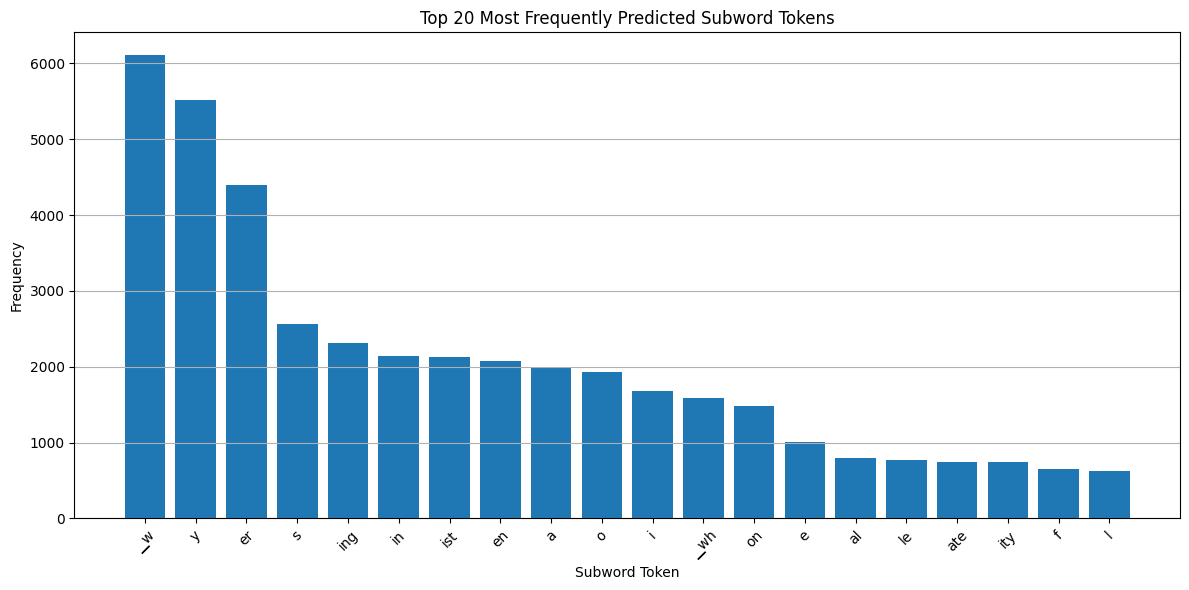

In [ ]:
# Convert token IDs to subword pieces
most_common = token_counter.most_common(20)
tokens = [sp_word.id_to_piece(tok_id) for tok_id, _ in most_common]
frequencies = [count for _, count in most_common]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(tokens, frequencies)
plt.title("Top 20 Most Frequently Predicted Subword Tokens")
plt.xlabel("Subword Token")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict, Counter
import numpy as np
from tqdm import tqdm

model.eval()

# Store: for each true token x at position t → list of model predicted probs
conditional_probs = defaultdict(list)
ground_truth_counts = Counter()

with torch.no_grad():
    for definition, word in tqdm(definition_to_word.items()):
        def_ids = sp_def.encode(str(definition), out_type=int)[:max_def_len]
        def_ids += [0] * (max_def_len - len(def_ids))

        word_ids = sp_word.encode(str(word), out_type=int)
        if not word_ids:
            continue

        # pad or truncate target
        word_ids = word_ids[:max_word_len]
        word_ids += [0] * (max_word_len - len(word_ids))

        input_tensor = torch.tensor([def_ids], dtype=torch.long).to(device)
        logits = model(input_tensor)[0]  # shape [word_len, vocab_size_word]

        probs = torch.softmax(logits, dim=-1).cpu().numpy()  # shape [word_len, vocab_size_word]

        for t, true_token in enumerate(word_ids):
            conditional_probs[true_token].append(probs[t])  # model's predicted dist at position t
            ground_truth_counts[true_token] += 1

total_count = sum(ground_truth_counts.values())
H_Y_given_X = 0.0

for x, prob_list in conditional_probs.items():
    p_x = ground_truth_counts[x] / total_count
    avg_entropy = 0.0

    for p_y_given_x in prob_list:
        log_p = np.log2(np.clip(p_y_given_x, 1e-12, 1.0))  # avoid log(0)
        entropy = -np.sum(p_y_given_x * log_p)
        avg_entropy += entropy

    avg_entropy /= len(prob_list)
    H_Y_given_X += p_x * avg_entropy

print(f"Conditional Entropy H(Y|X): {H_Y_given_X:.4f} bits")


100%|██████████| 52607/52607 [00:42<00:00, 1243.44it/s]


Conditional Entropy H(Y|X): 3.6557 bits


# **Word Embeddings Technique 2 Experiment**

Predict the next token based on the sequence of tokens(max seq length of 6)

In [ ]:
token_counter = Counter()
num_samples = 10000  # or len(definition_to_word) for all

# Sample
sampled_definitions = random.sample(list(definition_to_word.keys()), num_samples)

model2.eval()
with torch.no_grad():
    for definition in sampled_definitions:
        def_ids = sp_def.encode(definition, out_type=int)[:max_def_len]
        def_ids += [0] * (max_def_len - len(def_ids))
        input_tensor = torch.tensor([def_ids], dtype=torch.long).to(device)

        logits = model2(input_tensor)
        pred_ids = torch.argmax(logits[0], dim=-1).tolist()

        token_counter.update(pred_ids)

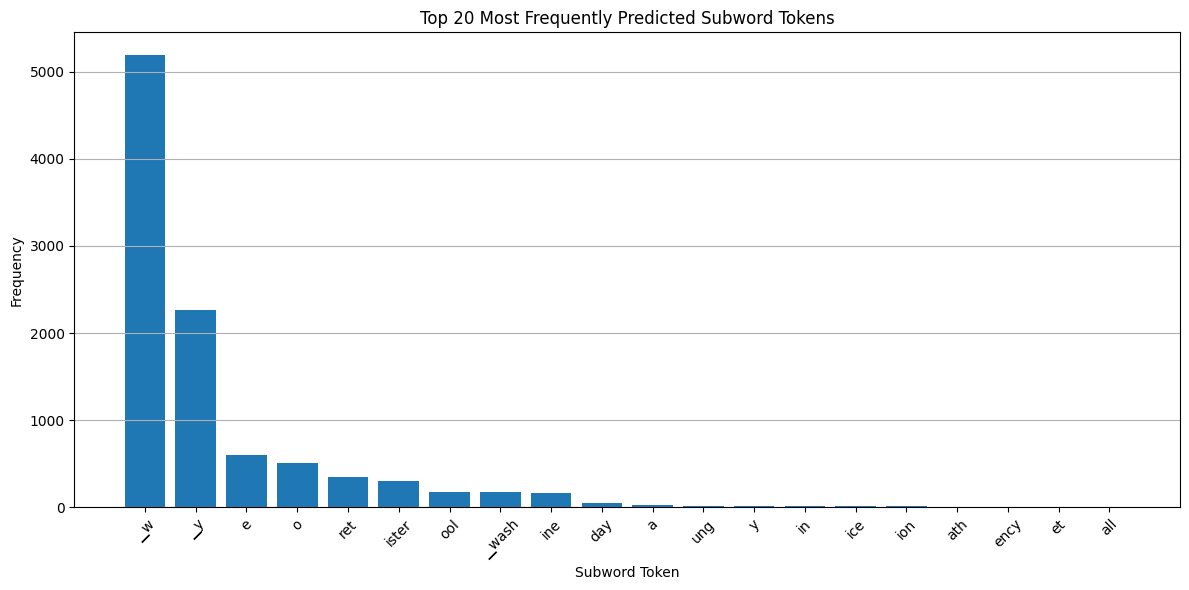

In [ ]:
# Convert token IDs to subword pieces
most_common = token_counter.most_common(20)
tokens = [sp_word.id_to_piece(tok_id) for tok_id, _ in most_common]
frequencies = [count for _, count in most_common]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(tokens, frequencies)
plt.title("Top 20 Most Frequently Predicted Subword Tokens")
plt.xlabel("Subword Token")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Collect p(y | x) for each true token x
conditional_probs = defaultdict(list)
ground_truth_counts = Counter()

sampled_definitions = random.sample(list(definition_to_word.items()), num_samples)

model2.eval()
with torch.no_grad():
    for definition, word in tqdm(sampled_definitions):
        def_ids = sp_def.encode(str(definition), out_type=int)[:max_def_len]
        word_ids = sp_word.encode(str(word), out_type=int)

        for word_idx in range(len(word_ids)):
            # Input is definition + previous subword tokens
            def_tks = def_ids + word_ids[0:word_idx]
            def_tks += [0] * (max_def_len - len(def_tks))
            def_tks = def_tks[-max_def_len:]

            input_tensor = torch.tensor([def_tks], dtype=torch.long).to(device)
            logits = model2(input_tensor)  # [1, vocab_size_word]
            probs = torch.softmax(logits[0], dim=-1).cpu().numpy()

            true_token = word_ids[word_idx]
            conditional_probs[true_token].append(probs)
            ground_truth_counts[true_token] += 1

total_count = sum(ground_truth_counts.values())
H_Y_given_X = 0.0

for x, prob_list in conditional_probs.items():
    p_x = ground_truth_counts[x] / total_count
    avg_cond_entropy = 0.0

    for p_y_given_x in prob_list:
        log_p = np.log2(np.clip(p_y_given_x, 1e-12, 1.0))  # avoid log(0)
        entropy = -np.sum(p_y_given_x * log_p)
        avg_cond_entropy += entropy

    avg_cond_entropy /= len(prob_list)
    H_Y_given_X += p_x * avg_cond_entropy

print(f"Conditional Entropy H(Y|X): {H_Y_given_X:.4f} bits")



100%|██████████| 10000/10000 [00:10<00:00, 979.47it/s]


Conditional Entropy H(Y|X): 2.2565 bits


# Entropy Analysis For Word Embeddings

The conditional entropy for the 1st technique and 2nd technique respectively were **~4.9 bits** and **~2.2 bits bits**.

**1st Technique (Higher Entropy)**:

*   Predicts all tokens simultaneously, with no feedback from previous generated tokens.
*   Each output token is predicted independently, conditioned only on the definition embedding
*   As a result, the model has less contextual information at each token position (it doesn't know what it has already predicted).
*   This causes greater uncertainty (higher entropy) in its predictions, especially for mid- or later subword positions.

**2nd Technique (Lower Entropy)**:

*   This model predicts tokens one by one — each token is conditioned on the definition + previously predicted tokens.
*   This allows the model to build structure over time, e.g., starting with "▁ab" makes "ash" more likely.
*   The extra context at each step leads to sharper, more confident predictions, reducing entropy.

We know that the first technique predicted the word's tokens all at once while the 2nd technique predicted the word token by token sequentially. For the first technique, the model doesn't necessarily know what it's already said, so it has to hedge its bets. For the second technique, the model has stronger constraints at each step and can "commit" to a more coherent sequence.

**Experimental Question**: Does the model, when generating words from definitions, over-rely on a small subset of subword tokens?

**Answer**: Yes — based on our findings (especially the conditional entropy values and token frequency histogram), our model does show signs of over-relying on a small subset of subword tokens, particularly when using the parallel prediction approach (first technique).

A small set of tokens (like "▁w", "fish", "wood", etc.) appear disproportionately often in predictions.

This indicates that, regardless of the input definition, the model tends to fall back on the same subword patterns.



---



---



# ***Results and Discussions for Multi-headed Attention***

# **Multi-headed Attention Experiment**

Finds most likely sequence of tokens out of 10 beams.

Outputs are coherent sometimes and sometimes outputs match the exact label. Qualitatively, the outputs from multi-headed attention are much more comprehensive and interpretable compared to results from word embeddings.

Calculates conditional entropy of outputs.

In [ ]:
if training_flag:
  token_counter = Counter()
  num_samples = 1000
  sampled_defs = random.sample(list(definition_to_word.keys()), num_samples)

  #count
  for definition in sampled_defs:
      pred = predict(definition)
      token_counter[pred] += 1

  # Plot top 20
  most_common = token_counter.most_common(20)
  words_top = [w for w,_ in most_common]
  freqs     = [c for _,c in most_common]

  plt.figure(figsize=(12,6))
  plt.bar(words_top, freqs)
  plt.title(f"Top 20 Most Frequently Predicted Words out of {num_samples} samples(Transformer)")
  plt.xlabel("Predicted Word")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45, ha="right")
  plt.tight_layout()
  plt.show()


In [ ]:
if training_flag:
  conditional_counts = defaultdict(Counter)
  ground_counts      = Counter()

  num_samples = 1000
  sampled_defs = random.sample(list(definition_to_word.items()), num_samples)

  for definition, actual in sampled_defs:
      pred = predict(definition)
      conditional_counts[actual][pred] += 1
      ground_counts[actual]      += 1

  total = sum(ground_counts.values())
  H_Y_given_X = 0.0

  for x, counter in conditional_counts.items():
      p_x   = ground_counts[x] / total
      total_x = sum(counter.values())
      H_x     = 0.0
      for count_xy in counter.values():
          p_y_given_x = count_xy / total_x
          H_x += -p_y_given_x * np.log2(p_y_given_x)
      H_Y_given_X += p_x * H_x

  print(f"Conditional Entropy H(Y|X): {H_Y_given_X:.4f} bits")

# Entropy Analysis for Multi-headed Attention

The conditional entropy for 10000 samples of multi-headed attention was **~0.02 bits**.

Considering word embeddings as a baseline, we can see that for the first technique using word embeddings that calculating each token in parallel resulted in a "safe" bet for each token but was also the **most uncertain(4.9)** out of the three. For the second technique using word embeddings, we calculated each token sequentially and this brought the entropy down by around half(**2.2**) because it could condition on previous outputs.

For this model, when given the next true subword token, can predict it with a very high level of certainty as seen with a very low conditional entropy. The model no longer hedges its bets by averaging but instead can pay full attention to pick the next subword.


**Experimental Question**: Can this reliance be mitigated through architectural choices like multi-headed attention?

**Answer**: Yes. That's because multi-headed self-attention gives the head a token-level representation of the entire definition allowing it to detext subtle semantic cues and patterns.

Each attention head in the transformer can specialize and focus on part-of-speech hints, semantic domains, etc. So the final pooled signal encodes far more information than the word embeddings do. As a result, the model no longer needs to **overrely** on “safe” tokens and can generate more diverse and accurate subwords directly from the definition.

# ***Citations/References***

HuggingFace GPT-2 Documentation:

https://huggingface.co/docs/transformers/en/model_doc/gpt2

Colab Notebook on Finetuning GPT-2:

https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing

Illustrated GPT-2:

https://jalammar.github.io/illustrated-gpt2/

